<a href="https://colab.research.google.com/github/yesimcebeci/Twitter-Sentiment-Analysis-on-Airlines/blob/main/Preprocessing_and_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [1]:
# !pip install sklearn
# !pip install wordcloud
# !pip install bs4
# !pip install nltk

In [3]:
# pip install --upgrade numpy


In [61]:
# !pip install gensim
!pip install gensim==4.2.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 33.7 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [1]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# importing necessary libraries for EDA and Cleaning
import pandas as pd
# increasing column width by using pandas display option
# This way we can see all given text
pd.options.display.max_colwidth = 200
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'
# Larger scale for plots in notebooks
sns.set_context('notebook')

# NLP
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
import emoji

# from imblearn.over_sampling import SMOTE

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV , StratifiedKFold

# Machine Learning Models
# from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
# from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier


from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional,Embedding
from keras.layers import Dropout, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
import gensim
from gensim.models import Word2Vec

# Evaluation Metrics
from sklearn import metrics 
from sklearn.metrics import roc_curve, auc, classification_report, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import f1_score,recall_score,precision_score,accuracy_score,confusion_matrix,plot_confusion_matrix


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
print(gensim.__version__)

4.2.0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
path = "/content/drive/MyDrive/Sentiment Analysis/Tweets.csv"
tweets_raw = pd.read_csv(path)

In [50]:
tweets_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

The US Airline Sentiment dataset has so many features. Among them, in this project I will be working with the **'airline' ,  'text'  and  'airline_sentiment'** features. Here, I will consider **'airline_sentiment'** as our target label for the classifier

The values in the target data are categorical and are 'neutral', 'positive' & 'negative'. For the easy computation, I will replace the 'neutral', 'positive' & 'negative' with 0, 1 & 2 values respectively.

In [51]:
# Drop dublicates if there is any
tweets = tweets_raw.drop_duplicates(subset=["tweet_id"], keep=False) 
tweets.shape

(14330, 15)

In [52]:
# Dropping unnecessary columns
tweets = tweets[['airline','text','airline_sentiment','negativereason']]
tweets.head()

,airline,text,airline_sentiment,negativereason
0,Virgin America,@VirginAmerica What @dhepburn said.,neutral,NaN
1,Virgin America,@VirginAmerica plus you've added commercials to the experience... tacky.,positive,NaN
2,Virgin America,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral,NaN
3,Virgin America,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative,Bad Flight
4,Virgin America,@VirginAmerica and it's a really big bad thing about it,negative,Can't Tell


In [53]:
tweets.isna().sum()

airline                 0
text                    0
airline_sentiment       0
negativereason       5338
dtype: int64

In [54]:
#Change Text to String
tweets["text"] = tweets["text"].astype(str)

#Remove neutral sentiment to focus on just the positive and negative sentiment
tweets = tweets[tweets["airline_sentiment"] != 'neutral']
tweets.shape

(11295, 4)

In [55]:
# in our case we are trying to find as possible as negative sentiment.I will assign negative sentiment as 1 , positive as 0
# replacing the categorical values of 'airline_sentiment' to numeric values as positive = 0 , negative = 1
tweets['airline_sentiment'].replace(('positive', 'negative'), (0, 1), inplace=True)
tweets['airline_sentiment'].value_counts()

1    8992
0    2303
Name: airline_sentiment, dtype: int64

## Text Preprocessing for Sentiment Analysis




Data cleaning was performed to improve the learning efficiency of machine learning models. Machine learning models show improved classification accuracy if the data are pre-processed.The pre-processing was done using the natural language toolkit.

In this part we will be:
- removing **tagged airlines** such as @united,
- converting text to **lowercase** (decreases the importance of more frequent terms in the text.)
- removing **numbers** (decreases the complexity of training the models)
- removing **punctuations** (it does not contribute to text analysis)
- removing **whitespace**,
- removing **emoji** (it does not contribute to text analysis)

In [56]:
tweets[['text']][1000:1020]


,text
1321,"@united just sent you a message on Facebook, how do I follow up a complaint re. Missing clothing out of checked baggage?"
1322,"@united why do I check in online if I still have to wait in line for an hour to ""check in"" at counter? #fuckinlame @naia_miaa"
1323,@united very poor customer service. I WILL think again befor Flight Booking Problems another United flight.
1324,@united an over booked flight to start with and a red eye from lax to bos with no reclining seat.... #lastflightwithyouever
1326,@united an efficient layout at kiosks/bag drop lines would help as there is no definition to space. Additional friendly and helpful staff
1327,"@united - 75% of a plane's passengers boarding in your ""Premier"" groups might be an indication of a broken process."
1329,@united EWR agent Barbara was FABULOUS and an example of CUST. SERV. A pleasure talking to you😊 http://t.co/KMQuLY9g5E
1330,"@united Cancelled Flightled a flight cause the crew needed sleep.But it's totally okay to wake me up at 3am just to let me know it's Cancelled Flightled, again."
1331,"@united changed my last name for my MileagePlus acct on the site in an hour. @BA_USA had me on hold for 20mins, then 5 days &amp; no change yet"
1332,"@united flight landed 13 hours ago, 2 more flights CMH-IAD last night and still no bag..could have driven it from CMH"


In [57]:
df = tweets.copy()

#Removing tagged airlines
df["text"] = df["text"].str.replace("(@+\w+)", "")

#Lowercasing text
df["text"] = df["text"].str.lower()

#Removing numbers
df["text"] = df["text"].str.replace('\d+', '', regex=True)

#Removing punctuations
def remove_punc(text):
    words_wo_punct = re.sub(r"[^A-Za-z0-9\s]+", "", text)
    return words_wo_punct

df["text"] = df["text"].apply(lambda x: remove_punc(x))

#Removing Whitespace
df["text"] = df["text"].str.strip()

#Removing emoji
df["text"] = df["text"].apply(lambda x: emoji.demojize(x))


In [58]:
df[['text']][1000:1020]


,text
1321,just sent you a message on facebook how do i follow up a complaint re missing clothing out of checked baggage
1322,why do i check in online if i still have to wait in line for an hour to check in at counter fuckinlame
1323,very poor customer service i will think again befor flight booking problems another united flight
1324,an over booked flight to start with and a red eye from lax to bos with no reclining seat lastflightwithyouever
1326,an efficient layout at kiosksbag drop lines would help as there is no definition to space additional friendly and helpful staff
1327,of a planes passengers boarding in your premier groups might be an indication of a broken process
1329,ewr agent barbara was fabulous and an example of cust serv a pleasure talking to you httptcokmqulyge
1330,cancelled flightled a flight cause the crew needed sleepbut its totally okay to wake me up at am just to let me know its cancelled flightled again
1331,changed my last name for my mileageplus acct on the site in an hour had me on hold for mins then days amp no change yet
1332,flight landed hours ago more flights cmhiad last night and still no bagcould have driven it from cmh


Finally, we do all the basic text cleanings like removal of user name mentions,hashtags, numbers etc using the function below. Next step is  I will keep preprocessing and will create another function. This function will:
- remove **stopwords** , 
- **tokenize** text and 
- **lemmatize** each word

In [59]:
# Creating variable for english stopwords.
stop_words = stopwords.words('english')

In [60]:
def cleaning(data):
    
    #Tokenize
    text_tokens = word_tokenize(data.replace("'", "")) 
    
    #Removing Stopwords
    tokens_without_sw = [t for t in text_tokens if t not in stop_words]  
    
    #lemma
    text_lemma = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]
    
    #joining
    cleaned_text = " ".join(text_lemma)

    return cleaned_text


In [61]:
#Applying function to target
df["text"] = df["text"].apply(cleaning)
df["text"].head()

1                                      plus youve added commercial experience tacky
3    really aggressive blast obnoxious entertainment guest face amp little recourse
4                                                              really big bad thing
5          seriously would pay flight seat didnt playing really bad thing flying va
6                                yes nearly every time fly vx ear worm wont go away
Name: text, dtype: object

- I preffered choose lemmatization instead of stemming, because the purpose of lemmatization is same as that of stemming but overcomes the drawbacks of stemming. In stemming, for some words, it may not give meaningful representation such as “Chang”. Here, lemmatization comes into picture as it gives meaningful word.

- Lemmatization takes more time as compared to stemming because it finds meaningful word/ representation. Stemming just needs to get a base word and therefore takes less time.

In [62]:
# Showing which words have the most counts in the all texts within each category.
FreqDist(" ".join(df["text"]).split()).most_common(50)

[('flight', 3684),
 ('get', 1122),
 ('hour', 1096),
 ('cancelled', 921),
 ('service', 910),
 ('thanks', 885),
 ('customer', 880),
 ('u', 877),
 ('time', 827),
 ('bag', 685),
 ('help', 682),
 ('plane', 646),
 ('im', 618),
 ('hold', 605),
 ('amp', 546),
 ('thank', 526),
 ('cant', 515),
 ('still', 513),
 ('call', 508),
 ('day', 500),
 ('delayed', 495),
 ('one', 489),
 ('airline', 488),
 ('gate', 481),
 ('need', 448),
 ('flightled', 438),
 ('back', 436),
 ('dont', 427),
 ('would', 419),
 ('delay', 411),
 ('phone', 406),
 ('hr', 402),
 ('got', 392),
 ('agent', 391),
 ('late', 390),
 ('seat', 389),
 ('please', 373),
 ('guy', 364),
 ('min', 349),
 ('like', 345),
 ('today', 344),
 ('waiting', 343),
 ('minute', 325),
 ('ive', 309),
 ('great', 308),
 ('make', 304),
 ('trying', 299),
 ('wait', 297),
 ('never', 296),
 ('fly', 295)]

In [63]:
# Showing which words have the most counts in the positive texts within each category.

all_positive_text = df.loc[df.airline_sentiment == 1].text.map(word_tokenize).values
all_positive_corpus = [word for text in all_positive_text for word in text]
freq =FreqDist(all_positive_corpus).most_common(50)
# all_positive_df = pd.DataFrame(freq, columns=['Word', 'Frequency'])
# all_positive_df

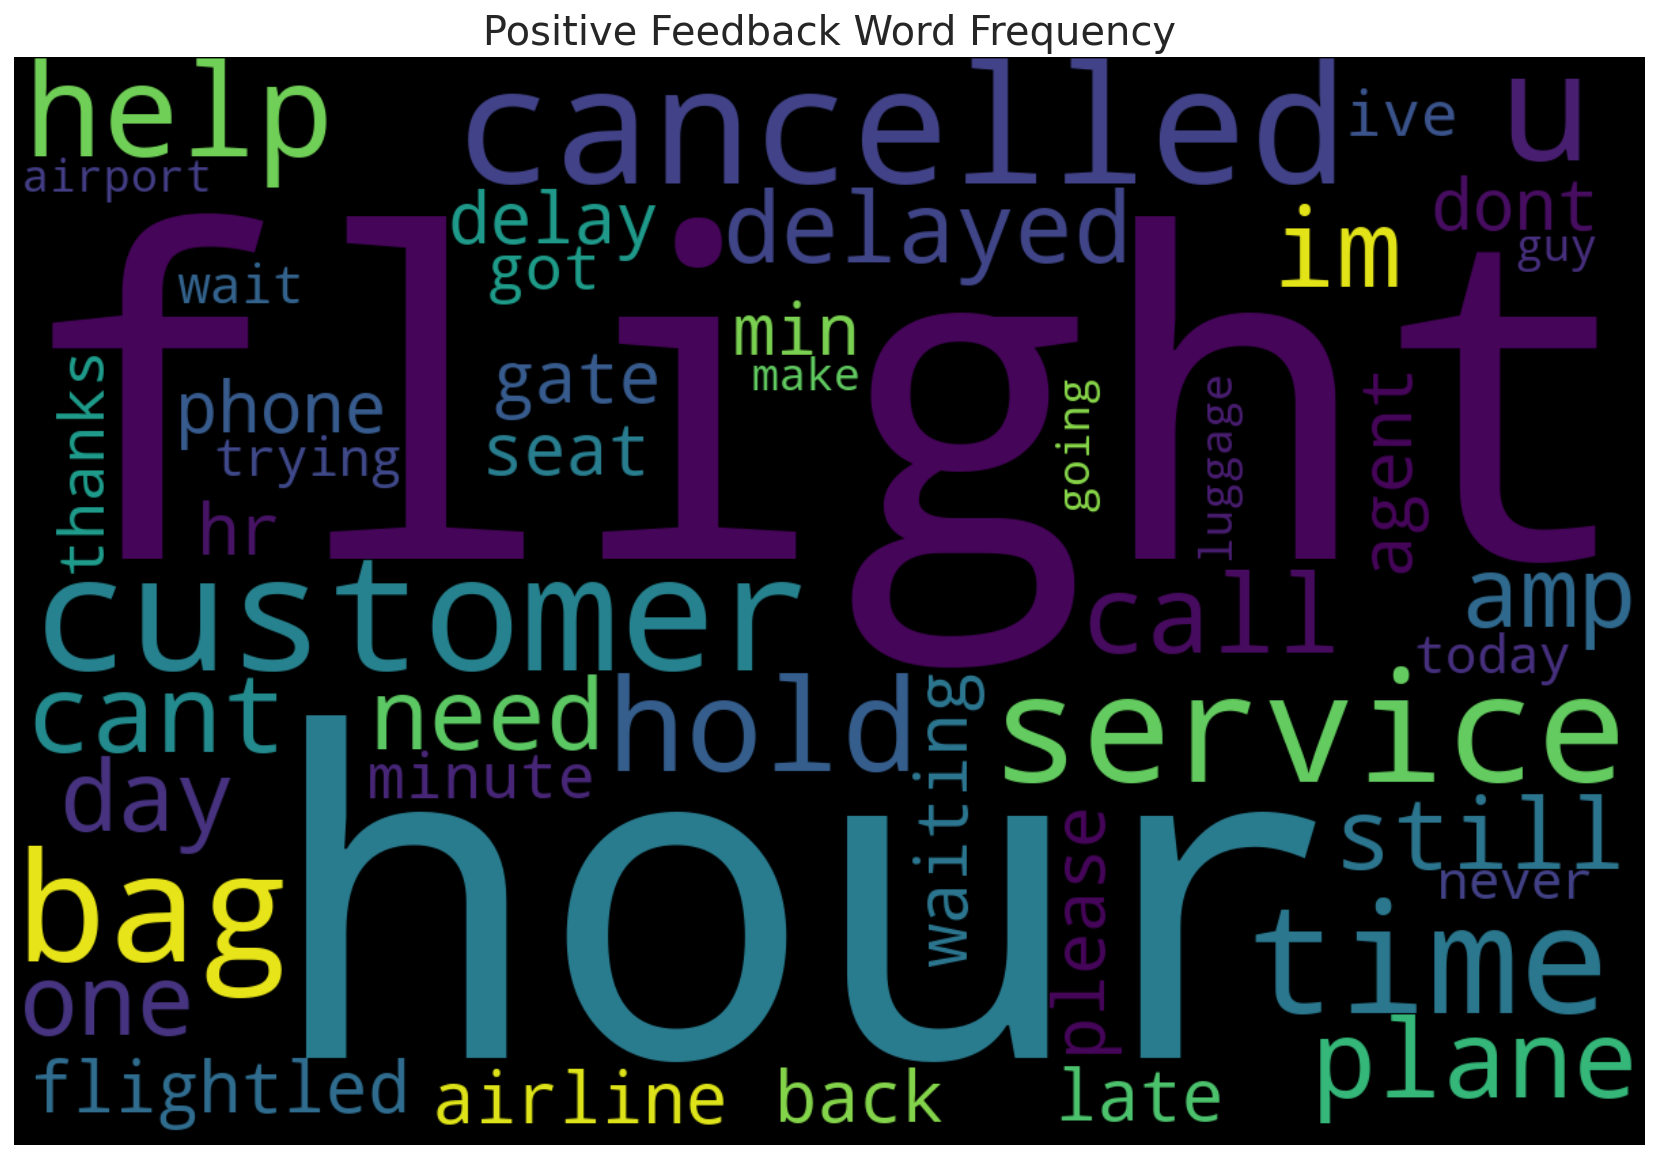

In [64]:
from wordcloud import WordCloud
all_positive_corpus = ' '.join(w[0] for w in freq)
airline_wordcloud = WordCloud(width = 1200, height = 800).generate(all_positive_corpus)


plt.figure(figsize=(20,10))
plt.imshow(airline_wordcloud, interpolation='bilinear')
plt.title('Positive Feedback Word Frequency' , fontsize = 20)
plt.axis("off")
plt.show()

- This bar chart shows us the top 50 most frequent words in positive feedback.The meaningful words that can be spotted in the positive sentiments’ word cloud directly include **“thank”**, **“flight”** and **“great”**. This shows people tend to appreciate the airline on social media when they have positive flight experience

In [65]:
# all_positive_df.set_index('Word')
# all_positive_df.plot.bar(x='Word', y='Frequency', figsize=(20,7))

# # Add title and axis names
# plt.title('Positive Feedback Word Frequency')
# plt.xlabel('Word')
# plt.ylabel('Frequency')
 
# # Show graphic
# plt.show()

In [66]:
# Showing which words have the most counts in the negative texts within each category.

all_negative_text = df.loc[df.airline_sentiment == 0].text.map(word_tokenize).values
all_negative_corpus = [word for text in all_negative_text for word in text]
freq = FreqDist(all_negative_corpus).most_common(50)

# all_negative_df = pd.DataFrame(freq, columns=['Word', 'Frequency'])
# all_negative_df

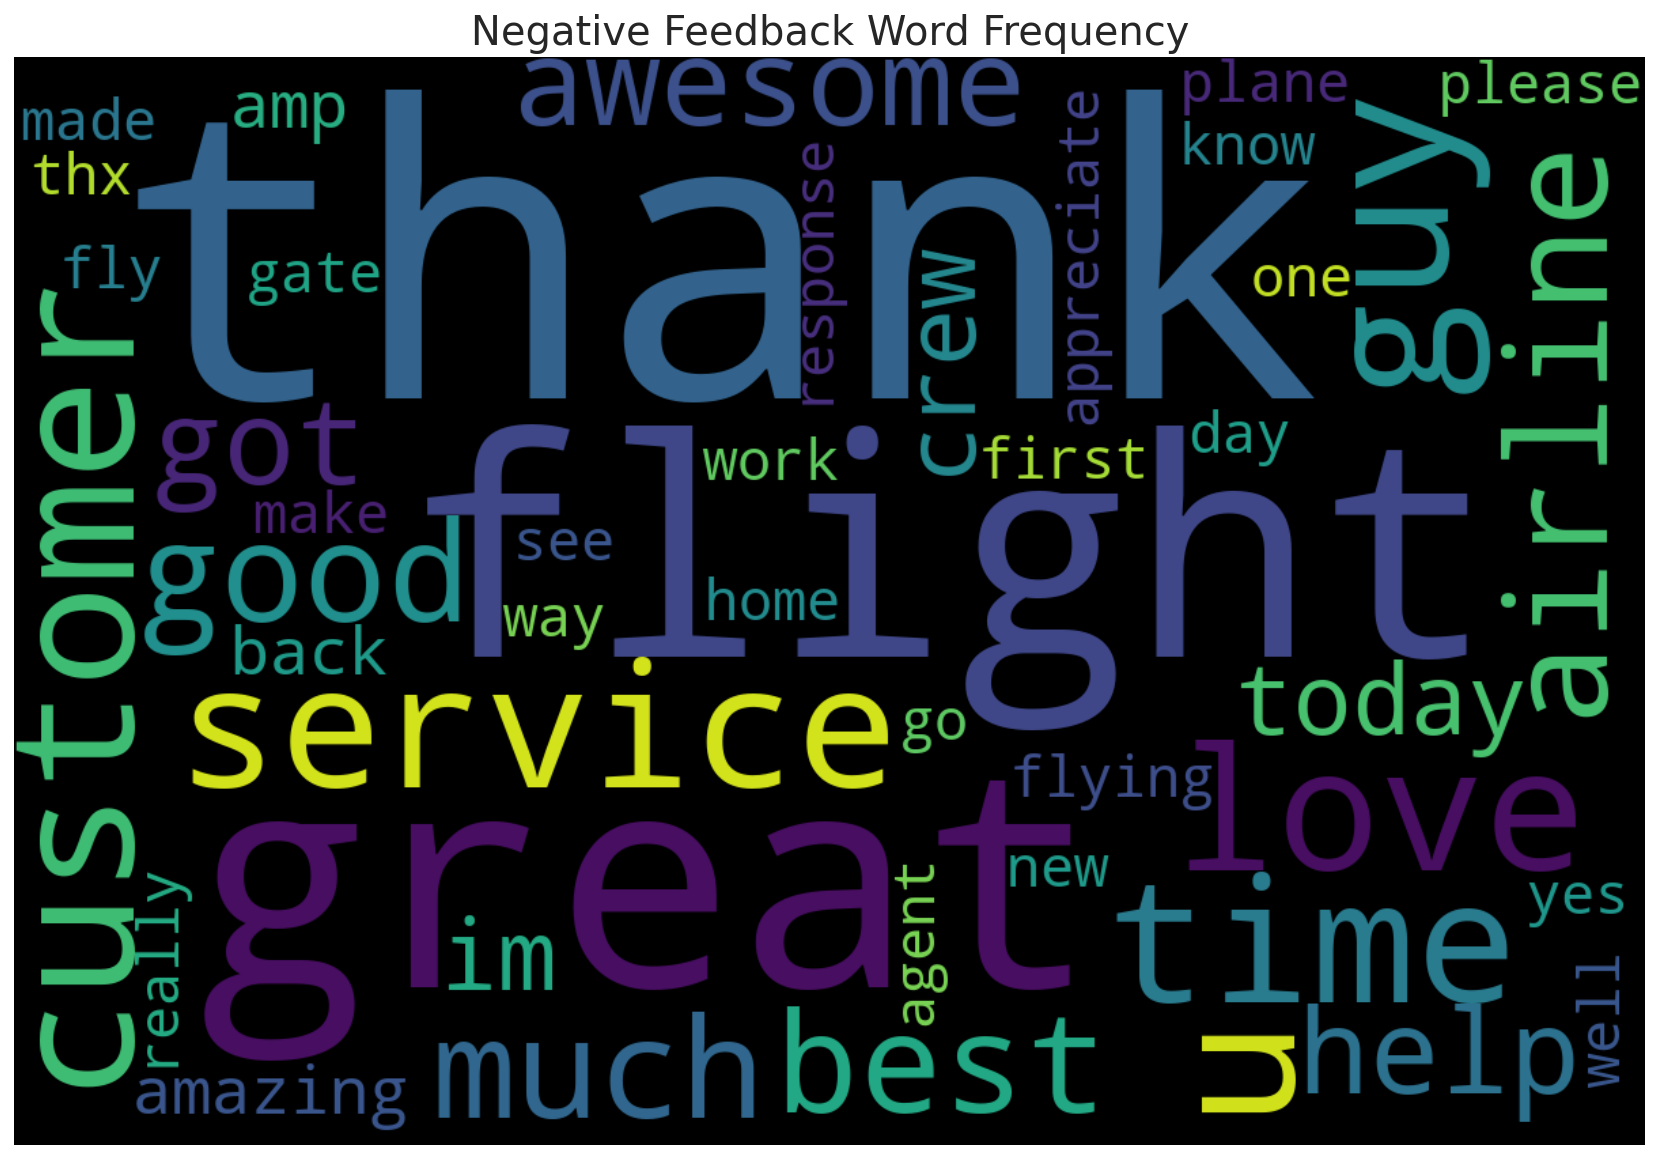

In [67]:
all_negative_corpus = ' '.join(w[0] for w in freq)
airline_wordcloud = WordCloud(width = 1200, height = 800).generate(all_negative_corpus)


plt.figure(figsize=(20,10))
plt.imshow(airline_wordcloud, interpolation='bilinear')
plt.title('Negative Feedback Word Frequency' , fontsize = 20)
plt.axis("off")
plt.show()

In [68]:
# all_negative_df.set_index('Word')
# all_negative_df.plot.bar(x='Word', y='Frequency', figsize=(20,7))

# # Add title and axis names
# plt.title('negative Feedback Word Frequency')
# plt.xlabel('Word')
# plt.ylabel('Frequency')
 
# # Show graphic
# plt.show()

- We observe from the word cloud that tweets related to **“cancelled”** are causing the most negative tweets. And also  **"Flight"**, **"hour"**, **"delayed"** have higher frequencies than other words.
- Also, **"cancelled"** shows that flight cancellation maybe the most important reason why customers are showing their negative feedback on Twitter.
- Other complaints were related to **customer service**,**layover**, **bag**,**hold**  and  **call**  as seen in the word cloud.



## Model Preparation

### Vectorization

Now we can make use of **TfidfVectorizer** and **CountVectorizer**  transfer Tweet contents into vectors, in order to train the model in the proper form and shape

So , What Is The Difference Between **TfidfVectorizer** and **CountVectorizer** ?

TF-IDF Vectorizer and Count Vectorizer are both methods used in natural language processing to vectorize text. However, there is a fundamental difference between the two methods.

- **CountVectorizer** simply counts the number of times a word appears in a document (using a bag-of-words approach).

-  **TF-IDF Vectorizer** takes into account not only how many times a word appears in a document but also how important that word is to the whole corpus.

After the vectorization phase, the data will be divide into **“training”** and **“testing”** set. It will be divide in the ratio of 4:1 for training and testing, respectively. Then we will be building predictive models on the dataset using feature set TF-IDF or CountVec.

### Model Selection

From [sklearn documentation](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) we can know which model we should use.

- The dataset sample amount is larger than 50.
- The model should predict a category.
- We have labeled data.
- The dataset sample amount is smaller than 100K.
- We have text data.

According to the machine learning map page, we can try both linear SVC (Support Vector Classification) model and Naive Bayes model, and choose the one with higher accuracy.

In [72]:
#Creating function to make comparisons aganist the models.
def evaluation(model, X_train, X_test):
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

#Visualize Confusion Matrix
    groupNames = ["True Neg", "False Pos", "False Neg", "True Pos"]
    groupCount = ["{0:0.0f}".format(value) for value in
                  cm.flatten()]
    groupPercent = ["{0:.2%}".format(value) for value in
                    cm.flatten()/np.sum(cm)]
                     
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(groupNames,groupCount,groupPercent)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cm, annot=labels, fmt='', cmap='rocket', annot_kws={"fontsize":15})
    plt.title("Confusion Matrix", fontsize=20)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('Actual label', fontsize=12)

    print("Accuracy score is: %.2f" % accuracy_score( y_test, y_pred))
    print("The F1 score is: %.2f" % f1_score( y_test, y_pred , average='weighted'))
    print('')
    print("The recall score is: %.2f" % recall_score( y_test, y_pred))
    print("The precision score is: %.2f" % precision_score( y_test, y_pred),"\n")

    training_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)

    print('')
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    

## CountVec

In [73]:
X = df['text']
y = df['airline_sentiment']

cv = CountVectorizer(min_df=5, max_df=0.70)
X_vec = cv.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, random_state=42)

### Get Base Model with Logistic Regression 

Accuracy score is: 0.87
The F1 score is: 0.85

The recall score is: 0.98
The precision score is: 0.87 


Accuracy on training data: 0.87
Accuracy on test data:     0.87


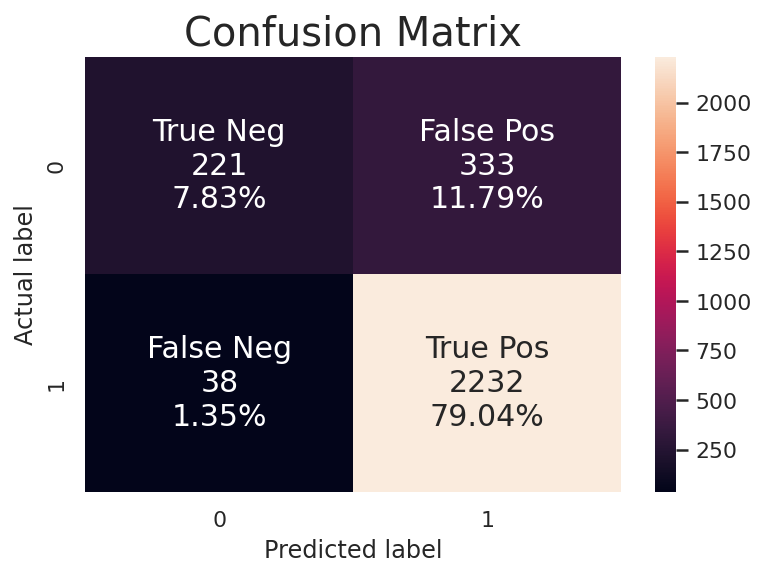

In [74]:
logReg_cv = LogisticRegression(max_iter=1000, C = 0.02).fit(X_train, y_train)
evaluation(logReg_cv, X_train, X_test)

- A logistic regression is trained with 75% of the tweet data. The model shows **87% accuracy** when applied on the test set

### **Understanding the Confusion Matrix**

- **True positives (TP)** : The model predicted that tweet is **negative** sentiment  and the tweet is actually **negative** sentiment.
- **False positives (FP)** :The model predicted that tweet is **negative** sentiment and the tweet is actually **positive** sentiment.
- **True negatives (TN)** : The model predicted that tweet is **positive** sentiment and the tweet is actually **positive** sentiment.
- **False negatives (FN)** : The model predicted that tweet is **positive** sentiment and the tweet is actually **negative** sentiment.


In this project, a **False Positive** would mean that the model predicted a tweet to be negative, but it was actually positive.The down side to this is that a bot would respond to a customer that had a positive experience and offer a discount or refund and cause a customer service representative to reach out when there isn’t a reason to. This will cause the company to lose money and waste time.

 A **False Negative** would mean that the model predicted a positive sentiment tweet, but it was actually a negative sentiment tweet. 
The down side to this is that the customer will not receive the proper customer service help and may never fly with a particular airline again. This will ultimately cause the airline company to lose money.

In this scenario, since both low recall and low precision have significant downsides, we could use the F1-score. We want to find as much as possible of the negative sentiment tweets. We also don't need bots and customer service representatives wasting time and money on responding to customers and offering discounts if the tweet is a positive sentiment. 
<!-- 
This metric might change based on an individual airline’s particular situation in which either finding more of the customers with negative sentiment or saving more money would take on more importance. The default threshold and the optimized F1-score have similar metrics. We would need a cost analysis of the false positives and compare them to the false negatives to determine the next best step for the airline. -->

### Naive Bayes

Accuracy score is: 0.91
The F1 score is: 0.91

The recall score is: 0.93
The precision score is: 0.95 


Accuracy on training data: 0.93
Accuracy on test data:     0.91


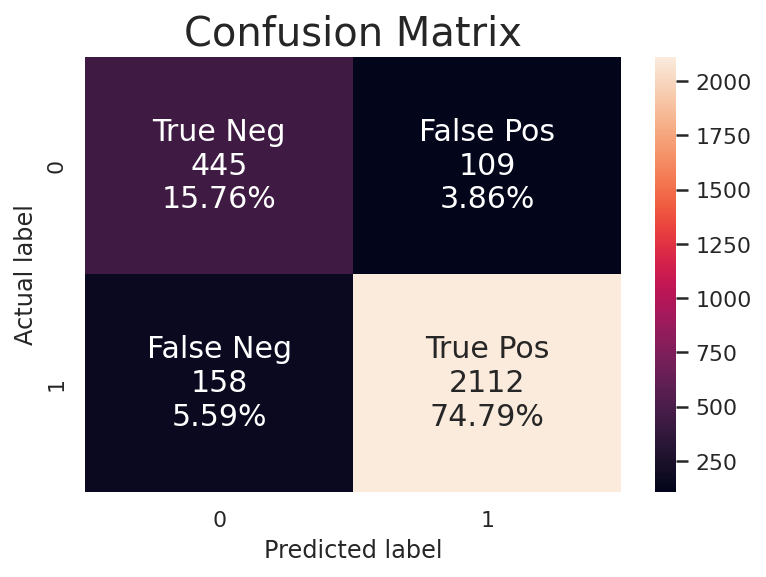

In [75]:
bnb_cv= BernoulliNB().fit(X_train, y_train)
evaluation(bnb_cv ,X_train, X_test)

- The accuracy score on the training data is higher than the accuracy score on the test data (0.93 vs 0.91). This could indicate that the model is overfitting to the training data, and performing worse on new, unseen data

### Support Vector Classifier 

Accuracy score is: 0.91
The F1 score is: 0.90

The recall score is: 0.98
The precision score is: 0.91 


Accuracy on training data: 0.96
Accuracy on test data:     0.91


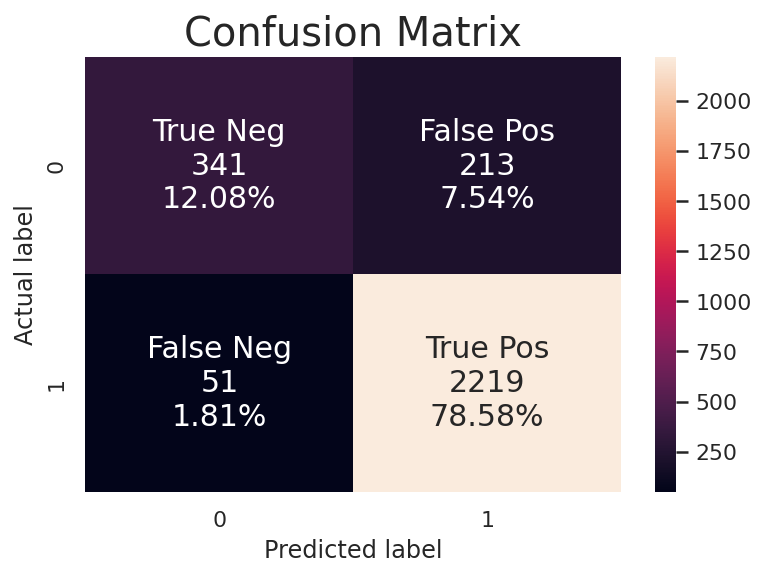

In [76]:
svc_cv = svm.SVC().fit(X_train, y_train)
evaluation(svc_cv ,X_train, X_test)

- The precision score of 0.87 suggests that the model is doing a good job at avoiding false positives. This is often more important in applications where false positives can lead to serious consequences. In our case, both low recall and low precision have significant downsides.
- It's also worth noting that the accuracy on the training data is significantly higher than the accuracy on the test data (0.96 vs 0.91).It indicates that the overfitting issue has worsened in this model.

### TF-IDF

In [77]:
X = df['text']
y = df['airline_sentiment']

tdidf = TfidfVectorizer(min_df=5, max_df=0.70)
X_vec = tdidf.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, random_state=42)

### Get Base Model with Logistic Regression

Accuracy score is: 0.81
The F1 score is: 0.74

The recall score is: 1.00
The precision score is: 0.81 


Accuracy on training data: 0.81
Accuracy on test data:     0.81


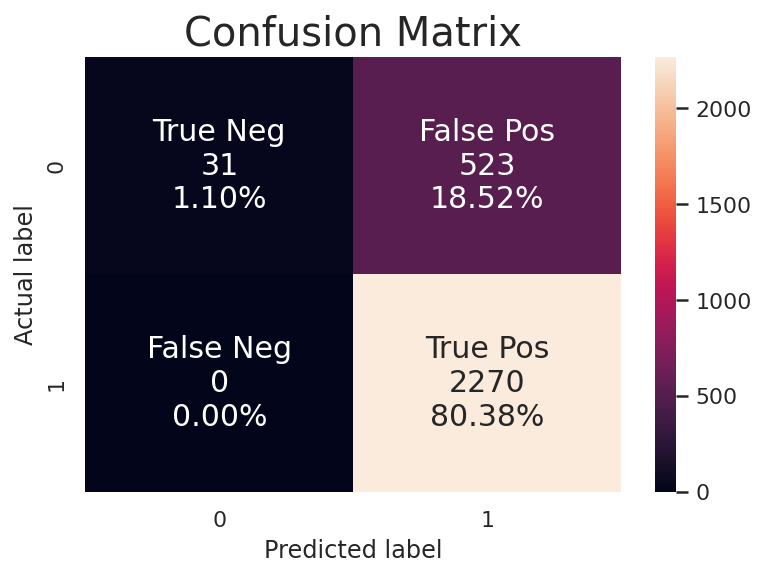

In [78]:
logReg_tfidf = LogisticRegression(max_iter=1000, C = 0.02).fit(X_train, y_train)
evaluation(logReg_tfidf ,X_train, X_test)

- The F1 score of 0.74 is somewhat low, indicating that the model is not balancing precision and recall well. The recall score of 0.06 is very low, which means that the model is likely missing a lot of relevant instances.
On the other hand, the precision score of 1.00 is extremely high, which means that the model is very certain about its predictions and is not making many false positives.

### Naive Bayes

Accuracy score is: 0.91
The F1 score is: 0.91

The recall score is: 0.93
The precision score is: 0.95 


Accuracy on training data: 0.93
Accuracy on test data:     0.91


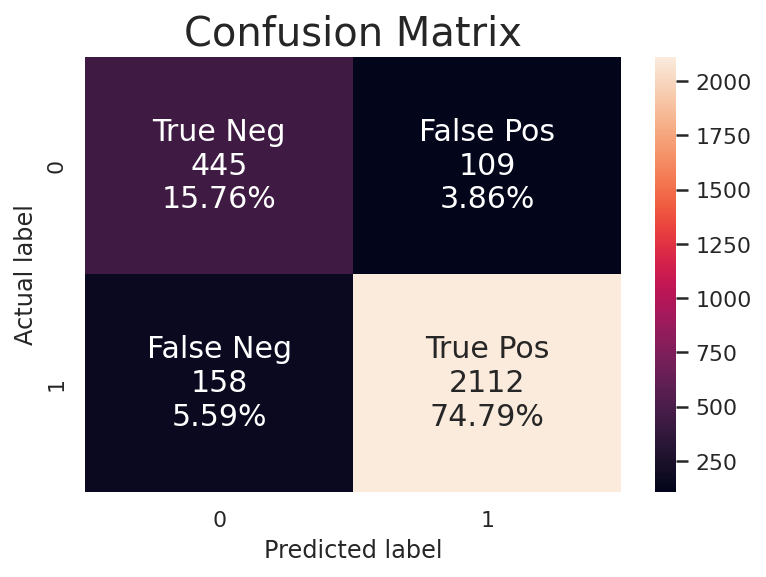

In [79]:
bnb_tfidf = BernoulliNB().fit(X_train, y_train)
evaluation(bnb_tfidf ,X_train, X_test)

- The accuracy on the training data is higher than the accuracy on the test data (0.93 vs 0.91). This could indicate that the model is overfitting to the training data
- The F1 score of 0.91 suggests that the model is balancing precision and recall well, which is good.

### Support Vector Classifier

Accuracy score is: 0.91
The F1 score is: 0.91

The recall score is: 0.98
The precision score is: 0.92 


Accuracy on training data: 0.98
Accuracy on test data:     0.91


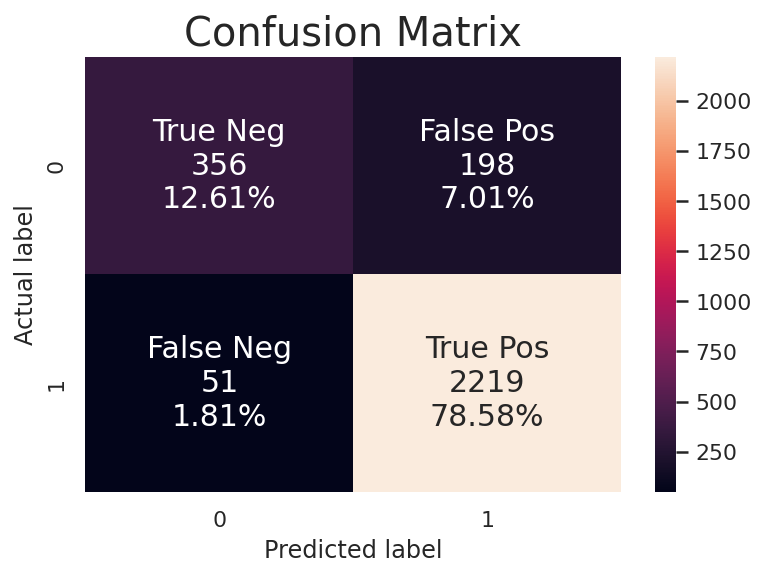

In [80]:
svc_tfidf = svm.SVC().fit(X_train, y_train)
evaluation(svc_tfidf ,X_train, X_test)

- The accuracy on the training data is significantly higher than the accuracy on the test data (0.98 vs 0.91). It indicates that the overfitting issue has worsened compared to previous models.

- **SVC_tfidf** (Support Vector Classifier)    model is slightly higher accuracy and F1 score compared to **Naive Bayes** model.





## Lets Improve the Model

In [81]:
X = df['text']
y = df['airline_sentiment']

tdidf = TfidfVectorizer(min_df=5, max_df=0.70)
X_vec = tdidf.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, random_state=42)

 **Tuning SVC**

In order to improve the model accuracy, there are several parameters need to be tuned. Three major parameters including:

- **Kernels:** The main function of the kernel is to take low dimensional input space and transform it into a higher-dimensional space. It is mostly useful in non-linear separation problem.

- **C (Regularisation):** C is the penalty parameter, which represents misclassification or error term. The misclassification or error term tells the SVM optimisation how much error is bearable. This is how you can control the trade-off between decision boundary and misclassification term.when C is high it will classify all the data points correctly, also there is a chance to overfit.

- **Gamma:** It defines how far influences the calculation of plausible line of separation.when gamma is higher, nearby points will have high influence; low gamma means far away points also be considered to get the decision boundary.



In [82]:
#8 mins
param_grid = {'C': [0.1,1, 10, 100],
              'gamma': [1,0.1,0.01,0.001],
              'kernel': ['rbf', 'poly', 'sigmoid']
              }

svc_gs = GridSearchCV(SVC(),
                      param_grid,
                      cv=5,
                      n_jobs = -1, # Setting n_jobs=-1 means to use all the CPU cores instead of just 1 (the default) 
                                   #This allows us to speed up the computation by performing tasks in parallel 
                      )

svc_gs.fit(X_train,y_train)

print(svc_gs.best_params_)
print(svc_gs.best_score_)



{'C': 100, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.9118155001340842


Accuracy score is: 0.91
The F1 score is: 0.91

The recall score is: 0.97
The precision score is: 0.93 


Accuracy on training data: 0.95
Accuracy on test data:     0.91


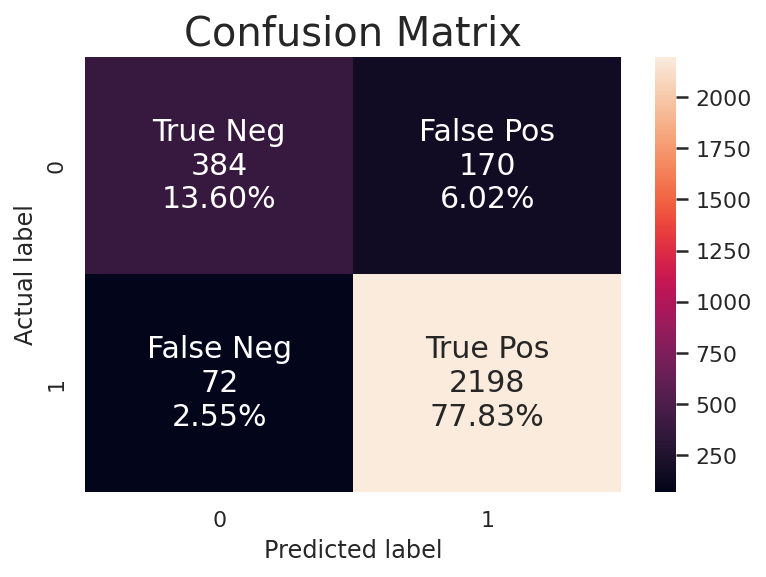

In [83]:
svc_tuned = SVC(C= 100, gamma= 0.01, kernel= 'sigmoid',probability=True).fit(X_train, y_train)
evaluation(svc_tuned ,X_train, X_test)


- Tuning SVC decreased overfitting

**Tuning Naive Bayes**

In [84]:
#We will perform a grid search on the alpha values
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
         }

#Using grid search
bnb_gs = GridSearchCV(BernoulliNB(),
                      param_grid=params,
                      n_jobs=-1,
                      cv=5)

#Fit on train data
bnb_gs.fit(X_train, y_train)

print(bnb_gs.best_params_)
print(bnb_gs.best_score_)


{'alpha': 1.0}
0.9048513406679135


Accuracy score is: 0.91
The F1 score is: 0.91

The recall score is: 0.93
The precision score is: 0.95 


Accuracy on training data: 0.93
Accuracy on test data:     0.91


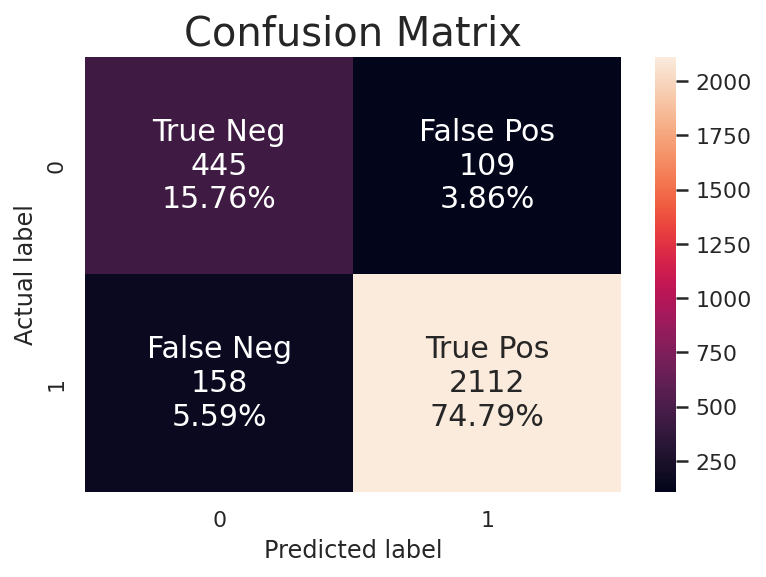

In [85]:
bnb_tuned = BernoulliNB(alpha= 1.0).fit(X_train, y_train)
evaluation(bnb_tuned ,X_train, X_test)

- Tuning Naive Bayes didnt make any difference.

### Predicting

In [86]:
pipe = Pipeline([('tfidf',TfidfVectorizer(min_df=5, max_df=0.70)),('svc',SVC(C= 100, gamma= 0.01, kernel= 'sigmoid'))])

In [87]:
pipe.fit(X,y)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.7, min_df=5)),
                ('svc', SVC(C=100, gamma=0.01, kernel='sigmoid'))])

In [88]:
tweet = df['text'].sample()
print(tweet)
tweet = pd.Series(tweet).apply(cleaning)
print(pipe.predict(tweet))

4375    tv stream mean get spend flight watching woman world cup final throwback bestflightever
Name: text, dtype: object
[1]


In [89]:
tweet = df['text'].sample()
print(tweet)
tweet = pd.Series(tweet).apply(cleaning)
print(pipe.predict(tweet))

605    tried one available bogota everyone rude houston stuck hour guy
Name: text, dtype: object
[1]


In [90]:
tweet = df['text'].sample()
print(tweet)
tweet = pd.Series(tweet).apply(cleaning)
print(pipe.predict(tweet))

2074    unhelpful team sure im bangkok bag chicago u going pay accommodation bag arrives
Name: text, dtype: object
[1]


In [91]:
tweet = df['text'].sample()
print(tweet)
tweet = pd.Series(tweet).apply(cleaning)
print(pipe.predict(tweet))

7154    nope rt fleet fleek httptcoshhtvioti
Name: text, dtype: object
[1]


In [92]:
tweet = df['text'].sample()
print(tweet)
tweet = pd.Series(tweet).apply(cleaning)
print(pipe.predict(tweet))

13990    trying add tsa pre check number reservation online dont see option nosecuritylines
Name: text, dtype: object
[1]


In [93]:
tweet = df['text'].sample()
print(tweet)
tweet = pd.Series(tweet).apply(cleaning)
print(pipe.predict(tweet))

1033    ok thank help
Name: text, dtype: object
[0]


In [94]:
tweet = df['text'].sample()
print(tweet)
tweet = pd.Series(tweet).apply(cleaning)
print(pipe.predict(tweet))

9666    usairways lost passenger today upholding promise excellent customer service
Name: text, dtype: object
[1]


In [95]:
tweet = df['text'].sample()
print(tweet)
tweet = pd.Series(tweet).apply(cleaning)
print(pipe.predict(tweet))

5664    guy flight attendant last flight hilarious
Name: text, dtype: object
[1]


The model appears to be working effectively and consistently making accurate predictions for sentiment classification.

**Comment!**<!-- The confusion matrix is an N x N matrix, that is used to evaluate the performance of a
machine learning classification model, N represent the output classes number. The matrix
cross check how the model been able to correctly classify each output correctly or not.
Moreover, then we can observe certain metrics from the matrix such as accuracy, which
can let us know how good is the model. -->

COmment!<!-- An effective machine learning model was built by training, testing,
and evaluating Support Vector Classifiers along with FastText embeddings. After several
steps of cleaning and pre-processing, Linear SVC gave a weighted average f1 score of
84%.
Since the sentiments clearly differs by the days of the week, the airline industry may have
to consider business decisions which take this analysis into account. For example, having
a varied work force of customer service representatives depending on the day of the week
may prove beneficial. Digging deeper down into the causes of negative sentiments may
also reveal some pain points, helping the airline industry in forming a plan of action to
mitigate these issues. -->

Comment!
<!-- 5.2 Recommendations and Future Work
More data can be scraped from Twitter using the third-party scraping tool and more
machine learning models can be tested.
To crystallize the analysis, all one has to do is take airline tweets from a larger duration
of choice and use this same approach of tagging the tweets, training using machine
learning models and predict the sentiments using our model. Further statistical analysis
can be done to check the correlation between the sentiment with the day of the week. -->

comment!
<!-- However, any airline is more concerned regarding the negative tweets recorded expressing the customer unsatisfaction so that they can work upon that particular aspect where they fail. So, our focus should be on minimising the FALSE POSITIVES thereby increasing the PRECISION value. Considering this factor RANDOM-FOREST (weighted_precision:0.841 ) appears to be the best classifier followed by NAIVE-BAYES (weighted_precision: 0.769).**bold text** -->

## Sequential

In [96]:
df2 = df[['airline_sentiment' , 'text']]
df2.index = np.arange(0, len(df2))
df2

,airline_sentiment,text
0,0,plus youve added commercial experience tacky
1,1,really aggressive blast obnoxious entertainment guest face amp little recourse
2,1,really big bad thing
3,1,seriously would pay flight seat didnt playing really bad thing flying va
4,0,yes nearly every time fly vx ear worm wont go away
...,...,...
11290,1,flight cancelled flightled leaving tomorrow morning auto rebooked tuesday night flight need arrive monday
11291,1,right cue delay
11292,0,thank got different flight chicago
11293,1,leaving minute late flight warning communication minute late flight thats called shitty customer svc


In [97]:
# Creating function to tokenize
def tokenize(d):
    return word_tokenize(d)

In [98]:
#Creating variable for tokenized target variable
texts_w2v = df2.text.apply(tokenize).to_list()

## Word2Vec Model


In [99]:
# Initialing Word2Vec Model
w2v = Word2Vec(sentences = texts_w2v, window=3,
              vector_size=100, min_count=5, workers=4,sg = 1) # if you want to set skip-gram sg=1 or  sg=0 for CBOW.
              #vector_size

In [100]:
texts_w2v[:3]

[['plus', 'youve', 'added', 'commercial', 'experience', 'tacky'],
 ['really',
  'aggressive',
  'blast',
  'obnoxious',
  'entertainment',
  'guest',
  'face',
  'amp',
  'little',
  'recourse'],
 ['really', 'big', 'bad', 'thing']]

- Word2Vec imported from gensim trains the texts at the same time as it is declared by the user.

- We can find the similar words with the given word and the examples are represented below.

In [101]:
# Similar words with the given word examples
w2v.wv.most_similar('thank')

[('much', 0.9776571393013),
 ('care', 0.9616138339042664),
 ('love', 0.956981360912323),
 ('amazing', 0.9557048678398132),
 ('awesome', 0.9452382326126099),
 ('twitter', 0.9414515495300293),
 ('thanks', 0.9393091797828674),
 ('appreciate', 0.9385842084884644),
 ('business', 0.9368299245834351),
 ('company', 0.9355891942977905)]

In [102]:
#Looking for simillar word with given words.
w2v.wv.most_similar('customerservice')

[('traveling', 0.9927567839622498),
 ('nightmare', 0.9926524758338928),
 ('fail', 0.9924513697624207),
 ('literally', 0.9922959804534912),
 ('extremely', 0.9922165274620056),
 ('killing', 0.9921815395355225),
 ('forever', 0.9919525980949402),
 ('abysmal', 0.9917746782302856),
 ('biggest', 0.9916791915893555),
 ('kidding', 0.9914579391479492)]

In [103]:
#Looking for similar word with given words
w2v.wv.most_similar("delay")

[('stuck', 0.9555016160011292),
 ('delayed', 0.9497053027153015),
 ('runway', 0.9408432245254517),
 ('ua', 0.9399259686470032),
 ('mechanical', 0.9387293457984924),
 ('sfo', 0.9376859068870544),
 ('sat', 0.9375117421150208),
 ('phl', 0.9328340291976929),
 ('jfk', 0.9306771159172058),
 ('departure', 0.9303020238876343)]

In [104]:
# Creating vectors for every text.
def get_avg_vector(sent):
    """
    This function makes vector for every sepcific words in our text data.
    """
    
    vector = np.zeros(100)
    total_words = 0
    for word in sent.split():        
        if word in w2v.wv.index_to_key:  
            vector += w2v.wv.word_vec(word)
            total_words += 1
    if total_words > 0:
        return vector / total_words
    else:
        return vector
    
df2['w2v_vector'] = df2['text'].map(get_avg_vector)
df2[['text', 'w2v_vector']].head(2)

,text,w2v_vector
0,plus youve added commercial experience tacky,"[-0.04703003875911236, 0.13287183344364167, 0.14155113697052002, 0.03988094106316566, 0.037919098511338234, -0.33655242919921874, 0.1370483011007309, 0.4249460279941559, -0.07630441933870316, -0.0..."
1,really aggressive blast obnoxious entertainment guest face amp little recourse,"[-0.04761106168319072, 0.14602594716208323, 0.1435126162001065, 0.04741773721096771, 0.04283721585358892, -0.3177665727479117, 0.09974656999111176, 0.34093989218984333, -0.043134815990924835, -0.0..."


In [105]:
# checking three diffent models accuracy for improve further.
model_params = {"random_state":42}
model_list = [LogisticRegression(**model_params , solver='liblinear'),
             RandomForestClassifier(**model_params),
             SVC(**model_params)]

model_name = ['LogisticRegression','RandomForest','SupportVectorMachine']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model, model_name in zip(model_list,model_name):
    for n_fold, (trn_idx, vld_idx) in enumerate(skf.split(df2.index, df2.airline_sentiment)):
        X_trn = np.stack(df2.loc[trn_idx, 'w2v_vector'])
        y_trn = df2.loc[trn_idx, "airline_sentiment"]
        
        X_vld = np.stack(df2.loc[vld_idx, "w2v_vector"])
        y_vld = df2.loc[vld_idx, "airline_sentiment"]
        
        model.fit(X_trn, y_trn)
        pred_col = f"{model_name}_w2v_pred"
        df2.loc[vld_idx, pred_col] = model.predict(X_vld)
        
    print(f"Model: {model_name}, Word2Vec, Accuracy: {accuracy_score(df2.airline_sentiment, df2[pred_col]):.3%}\n")

Model: LogisticRegression, Word2Vec, Accuracy: 86.330%

Model: RandomForest, Word2Vec, Accuracy: 87.012%

Model: SupportVectorMachine, Word2Vec, Accuracy: 86.490%



- We found that the results aren't be improved on the traditional ML algorithms.

It is known that effect from using embedding vector like Word2Vec usually maximizes by using sequence model like RNN.

## Long Short Term Memory Networks (LSTM)

In [106]:
#Specifing our target variable
X = df2['text']
y = df2['airline_sentiment']

In [107]:
#Encoding the target variable
y = pd.get_dummies(y).values

In [108]:
#Tokenizing our data, converting to sequence and padding to the same length
tokenizer =Tokenizer(num_words=5000) # lower=True, split=' '
tokenizer.fit_on_texts(df2['text'])
list_tokenized_headlines = tokenizer.texts_to_sequences(df2['text'])
X_t = pad_sequences(list_tokenized_headlines, maxlen=100 , padding='post') #padding='post'

print('Before Tokenization & Padding \n', df2['text'][3],'\n')
print('After Tokenization & Padding \n', X_t[3])

Before Tokenization & Padding 
 seriously would pay flight seat didnt playing really bad thing flying va 

After Tokenization & Padding 
 [ 263   29  171    1   36   98 1782   52  115  184   71 1512    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [109]:
#Splitting our data with a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.2, random_state=42, stratify=y)
X_trn, X_vld, y_trn, y_vld = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

print('Train:'            ,X_trn.shape, y_trn.shape)
print('Validation Set:'   ,X_vld.shape, y_vld.shape)
print('Test Set:'         ,X_test.shape, y_test.shape)

Train: (6325, 100) (6325, 2)
Validation Set: (2711, 100) (2711, 2)
Test Set: (2259, 100) (2259, 2)


In [110]:
vocab_size = 5000
embedding_size = 32
epochs=50
max_words = 5000
max_len = 100
batch_size = 64

#Insantiate the model
model= Sequential()

# embed our model of size 32, to an embedding space of 5000
# which reps the total vocabulary we want
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))

# add another layer with an activation function of 'relu' Rectified Linear Activation
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, padding='same'))

# Feed the data into an LSTM(Long Short Term Memory) with 32 nodes
model.add(Bidirectional(LSTM(32)))

# add a dropout layer to reduce overfitting
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

In [111]:
#Model compilation
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [112]:
#Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 32)           160000    
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 32)           3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                

In [113]:
#Trying early stopping to prevent overfitting
es = EarlyStopping(monitor = 'val_loss', patience=5)
batch_size = 64
  
history = model.fit(X_trn, y_trn, validation_data=(X_vld, y_vld), batch_size=batch_size, epochs=epochs, verbose=1, callbacks = es)

Epoch 1/50
99/99 [==============================] - 10s 65ms/step - loss: 0.4773 - accuracy: 0.7918 - val_loss: 0.3252 - val_accuracy: 0.8632
Epoch 2/50
99/99 [==============================] - 8s 79ms/step - loss: 0.2181 - accuracy: 0.9179 - val_loss: 0.2345 - val_accuracy: 0.9045
Epoch 3/50
99/99 [==============================] - 7s 70ms/step - loss: 0.1173 - accuracy: 0.9609 - val_loss: 0.2465 - val_accuracy: 0.9126
Epoch 4/50
99/99 [==============================] - 5s 55ms/step - loss: 0.0778 - accuracy: 0.9744 - val_loss: 0.2775 - val_accuracy: 0.9082
Epoch 5/50
99/99 [==============================] - 6s 56ms/step - loss: 0.0534 - accuracy: 0.9842 - val_loss: 0.3007 - val_accuracy: 0.9074
Epoch 6/50
99/99 [==============================] - 5s 55ms/step - loss: 0.0375 - accuracy: 0.9892 - val_loss: 0.3639 - val_accuracy: 0.9048
Epoch 7/50
99/99 [==============================] - 5s 55ms/step - loss: 0.0249 - accuracy: 0.9927 - val_loss: 0.4191 - val_accuracy: 0.9048


In [114]:
#Evaluate the model
loss, accuracy = model.evaluate(X_test,y_test ,  verbose=0)
print('Accuracy  : {:.2f}'.format(accuracy))

Accuracy  : 0.90


- The log shows that the training loss decreases and accuracy increases as the number of epochs increases. However, the validation loss and accuracy values tend to increase slightly after a few epochs. This suggests that the network is starting to overfit to the training data. 

<!-- To address this issue, regularization techniques, such as dropout, could be applied to the network, or the training process could be stopped earlier. -->

71/71 [==============================] - 3s 17ms/step


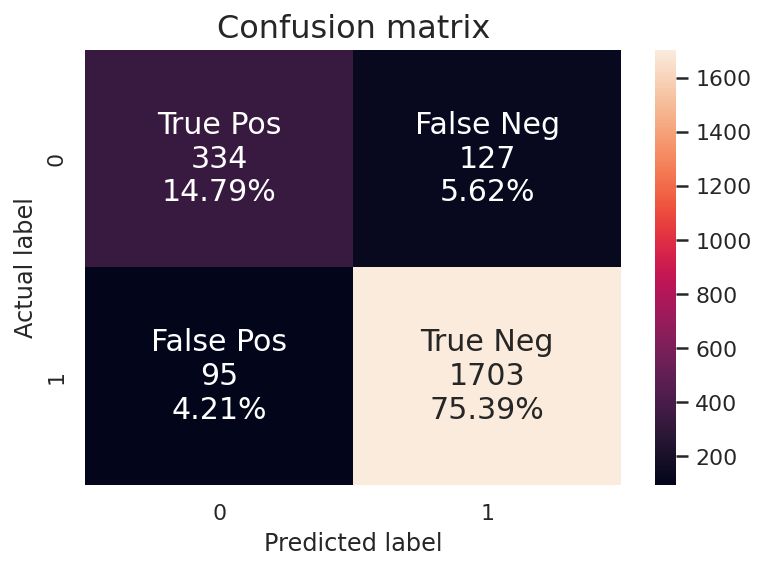

In [115]:
def plot_confusion_matrix(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))

#Visualize Confusion Matrix
    groupNames = ["True Pos", "False Neg", "False Pos", "True Neg"]
    groupCount = ["{0:0.0f}".format(value) for value in
                  cm.flatten()]
    groupPercent = ["{0:.2%}".format(value) for value in
                    cm.flatten()/np.sum(cm)]
                     
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(groupNames,groupCount,groupPercent)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cm, annot=labels, fmt='', cmap='rocket', annot_kws={"fontsize":15})
    plt.title("Confusion Matrix", fontsize=16)

    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('Actual label', fontsize=12)
  
plot_confusion_matrix(model, X_test, y_test)
    